In [1]:
data_inicial = '02/01/2019'
data_final   = '30/12/2022'

treino_data_inicial = '03/01/2019'
treino_data_final   = '26/10/2021'
teste_data_inicial  = '27/10/2021'
teste_data_final    = '29/12/2022'

ticker        = 'TUPY3'


#### Modelo de fatores para retorno de ativos

O excesso de retorno do ativo \( i \) no período \( t \) é dado por:

$$
R_{i,t} -  r_{f,t} = \alpha  + \beta_1 \,\text{Market}_t + \beta_2 \,\text{HML}_t + \beta_3 \,\text{SMB}_t + \beta_4 \,\text{WML}_t + \varepsilon_t
$$

##### Definição dos termos

- **$ R_{i,t} $**: retorno do ativo \( i \) no período \( t \).

- **$ r_{f,t} $**: retorno do ativo livre de risco no período \( t \).

- **$ \alpha $**: alfa do ativo, que mede o retorno médio não explicado pelos fatores de risco.

- **$ \text{Market}_t $**: fator mercado (prêmio de mercado), definido por:
  $  \text{Market}_t = R_{m,t} - r_{f,t} $

- **$ \text{SMB}_t $** (*Small Minus Big*): fator tamanho, representando a diferença de retorno entre empresas pequenas e grandes.

- **$ \text{HML}_t $** (*High Minus Low*): fator valor, representando a diferença de retorno entre empresas com alto e baixo índice book-to-market.

- **$ \text{WML}_t $** (*Winners Minus Losers*): fator momentum, representando a diferença de retorno entre ativos com bom e mau desempenho recente.

- **$ \beta_1, \beta_2, \beta_3, \beta_4 $**: coeficientes que medem a sensibilidade do retorno do ativo a cada fator de risco.

- **$ \varepsilon_t $**: termo de erro, que captura a parte do retorno não explicada pelos fatores.



In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import urllib.request
import urllib.error
from io import StringIO
import time

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

import matplotlib.pyplot as plt

def converter_data(data_str):
    """
    Converte string de data para formato datetime
    Aceita formatos: 'DD/MM/YYYY' ou 'YYYY-MM-DD'
    """
    formatos = ['%d/%m/%Y', '%Y-%m-%d', '%d-%m-%Y']
    
    for formato in formatos:
        try:
            return datetime.strptime(data_str, formato)
        except ValueError:
            continue
    
    raise ValueError(f"Formato de data não reconhecido: {data_str}. Use 'DD/MM/YYYY' ou 'YYYY-MM-DD'")


def baixar_precos_b3(ticker, periodo='1y', intervalo='1d', data_inicio=None, data_fim=None):
    """
    Baixa preços de ativos da B3 usando yfinance
    
    Parâmetros:
    ticker (str): Código do ativo (ex: 'PETR4.SA', 'VALE3.SA', 'ITUB4.SA')
    periodo (str): Período de dados ('1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', 'max')
    intervalo (str): Intervalo dos dados ('1m', '2m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo', '3mo')
    data_inicio (str): Data de início no formato 'DD/MM/YYYY' ou 'YYYY-MM-DD' (opcional)
    data_fim (str): Data de fim no formato 'DD/MM/YYYY' ou 'YYYY-MM-DD' (opcional)
    
    Retorna:
    DataFrame com os preços históricos
    """
    
    # Adiciona .SA se não estiver presente (sufixo da B3 no Yahoo Finance)
    if not ticker.endswith('.SA'):
        ticker = f"{ticker}.SA"
    
    print(f"Baixando dados de {ticker}...")
    
    try:
        # Converte datas se fornecidas
        start_date = None
        end_date = None
        
        if data_inicio:
            start_date = converter_data(data_inicio)
        
        if data_fim:
            end_date = converter_data(data_fim)
        
        # Baixa os dados
        ativo = yf.Ticker(ticker)
        
        # Se datas específicas forem fornecidas, usa start e end
        if start_date or end_date:
            dados = ativo.history(start=start_date, end=end_date, interval=intervalo)# , auto_adjust=False)
        else:
            dados = ativo.history(period=periodo, interval=intervalo)# auto_adjust=False)
        
        if dados.empty:
            print(f"Nenhum dado encontrado para {ticker}")
            return None
        
        # Informações adicionais do ativo
        info = ativo.info
        
        print(f"\n{'='*60}")
        print(f"Ativo: {ticker}")
        print(f"Nome: {info.get('longName', 'N/A')}")
        print(f"Setor: {info.get('sector', 'N/A')}")
        print(f"Total de registros: {len(dados)}")
        print(f"{'='*60}\n")
        
        return dados
    
    except Exception as e:
        print(f"Erro ao baixar dados: {e}")
        return None



def regressao_statsmodels(X_train, y_train, X_test, y_test, mostrar_summary=True):
    """
    Regressão linear usando statsmodels com análise estatística completa
    
    Parâmetros:
    -----------
    X_train : DataFrame ou array
        Variáveis independentes (fatores) de treino
    y_train : Series ou array
        Variável dependente (retorno_excesso) de treino
    X_test : DataFrame ou array
        Variáveis independentes de teste
    y_test : Series ou array
        Variável dependente de teste
    mostrar_summary : bool
        Se True, imprime o resumo completo da regressão
    
    Retorna:
    --------
    dict : Dicionário com modelo e resultados
    """
    # Adicionar constante (intercepto)
    X_train_sm = sm.add_constant(X_train)
    X_test_sm = sm.add_constant(X_test)
    
    # Ajustar o modelo
    modelo = sm.OLS(y_train, X_train_sm).fit()
    
    # Previsões
    y_pred_train = modelo.predict(X_train_sm)
    y_pred_test = modelo.predict(X_test_sm)
    
    # Calcular R² para teste
    r2_test = r2_score(y_test, y_pred_test)

     # Intercepto
    print(f"\nIntercepto (Alpha): {modelo.params['const']:.6f}")
    print(f"  Erro Padrão: {modelo.bse['const']:.6f}")
    print(f"  P-valor: {modelo.pvalues['const']:.6f}")
    
    # Coeficientes
    print("\nCoeficientes (Betas):")
    for nome in modelo.params.index:
        if nome != 'const':
            print(f"  {nome}:")
            print(f"    Coeficiente: {modelo.params[nome]:.6f}")
            print(f"    Erro Padrão: {modelo.bse[nome]:.6f}")
            print(f"    P-valor: {modelo.pvalues[nome]:.6f}")
    
    # Estatísticas gerais
    print("\n" + "-" * 80)
    print("ESTATÍSTICAS DO MODELO")
    print("-" * 80)
    print(f"R²: {modelo.rsquared:.4f}")
    print(f"R² Ajustado: {modelo.rsquared_adj:.4f}")
    print(f"Estatística F: {modelo.fvalue:.4f}")
    print(f"P-valor F: {modelo.f_pvalue:.6f}")
    
    if mostrar_summary:
        print("=" * 80)
        print("REGRESSÃO COM STATSMODELS --- SUMMARY")
        print("=" * 80)
        print(modelo.summary())
        print(f"\nR² dos dados de Teste: {r2_test:.4f}")
        print("=" * 80)
  
    return {
        'modelo': modelo,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test,
        'r2_train': modelo.rsquared,
        'r2_adj_train': modelo.rsquared_adj,
        'r2_test': r2_test,
        'coeficientes': modelo.params,
        'pvalores': modelo.pvalues,
        'intervalo_confianca': modelo.conf_int()
    }


def obter_anova_manual(resultado_statsmodels):
    """
    Cria tabela ANOVA manualmente a partir do resultado da regressao_statsmodels
    """
    import pandas as pd
    
    modelo = resultado_statsmodels['modelo']
    
    # Graus de liberdade
    df_model = modelo.df_model  # k (número de variáveis)
    df_resid = modelo.df_resid  # n - k - 1
    df_total = df_model + df_resid  # n - 1
    
    # Soma dos quadrados
    ss_model = modelo.ess  # Explained Sum of Squares (modelo)
    ss_resid = modelo.ssr  # Residual Sum of Squares (resíduo)
    ss_total = ss_model + ss_resid  # Total
    
    # Média dos quadrados
    ms_model = ss_model / df_model
    ms_resid = ss_resid / df_resid
    
    # Estatística F e p-valor
    f_stat = modelo.fvalue
    f_pvalue = modelo.f_pvalue
    
    # Criar tabela ANOVA
    anova_table = pd.DataFrame({
        'Fonte de Variação': ['Regressão', 'Resíduo', 'Total'],
        'GL': [int(df_model), int(df_resid), int(df_total)],
        'SQ': [ss_model, ss_resid, ss_total],
        'MQ': [ms_model, ms_resid, '-'],
        'F': [f'{f_stat:.4f}', '-', '-'],
        'P-valor': [f'{f_pvalue:.6f}' if f_pvalue < 0.001 else f'{f_pvalue:.4f}', '-', '-']
    })
    
    print("=" * 80)
    print("TABELA ANOVA")
    print("=" * 80)
    print(anova_table.to_string(index=False))
    print("=" * 80)
    print(f"\nR² = {modelo.rsquared:.4f} ({modelo.rsquared*100:.2f}% da variância explicada)")
    print(f"R² Ajustado = {modelo.rsquared_adj:.4f}")
    print("=" * 80)
    
    return anova_table


def regressao_sklearn(X_train, y_train, X_test, y_test, mostrar_resultados=True):
    """
    Regressão linear usando sklearn focada em predição
    
    Parâmetros:
    -----------
    X_train : DataFrame ou array
        Variáveis independentes (fatores) de treino
    y_train : Series ou array
        Variável dependente (retorno_excesso) de treino
    X_test : DataFrame ou array
        Variáveis independentes de teste
    y_test : Series ou array
        Variável dependente de teste
    mostrar_resultados : bool
        Se True, imprime os resultados principais
    
    Retorna:
    --------
    dict : Dicionário com modelo e resultados
    """
    # Criar e treinar o modelo
    modelo = LinearRegression()
    modelo.fit(X_train, y_train)
    
    # Previsões
    y_pred_train = modelo.predict(X_train)
    y_pred_test = modelo.predict(X_test)
    
    # Métricas
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    
    # R² ajustado manual
    n = len(y_train)
    p = X_train.shape[1]
    r2_adj_train = 1 - (1 - r2_train) * (n - 1) / (n - p - 1)
    
    if mostrar_resultados:
        print("=" * 80)
        print("REGRESSÃO COM SKLEARN")
        print("=" * 80)
        print(f"\nIntercepto (Alpha): {modelo.intercept_:.6f}")
        print("\nCoeficientes (Betas):")
        
        if hasattr(X_train, 'columns'):
            for nome, coef in zip(X_train.columns, modelo.coef_):
                print(f"  {nome}: {coef:.6f}")
        else:
            for i, coef in enumerate(modelo.coef_):
                print(f"  Fator {i+1}: {coef:.6f}")
        
        print(f"\nR² Treino: {r2_train:.4f}")
        print(f"R² Ajustado Treino: {r2_adj_train:.4f}")
        print(f"R² Teste: {r2_test:.4f}")
        print(f"\nMSE Treino: {mse_train:.6f}")
        print(f"MSE Teste: {mse_test:.6f}")
        print("=" * 80)
    
    return {
        'modelo': modelo,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test,
        'r2_train': r2_train,
        'r2_adj_train': r2_adj_train,
        'r2_test': r2_test,
        'mse_train': mse_train,
        'mse_test': mse_test,
        'coeficientes': modelo.coef_,
        'intercepto': modelo.intercept_
    }

In [3]:
precos = baixar_precos_b3(ticker, data_inicio=data_inicial, data_fim=data_final)
precos.index = precos.index.date
precos

Baixando dados de TUPY3.SA...

Ativo: TUPY3.SA
Nome: Tupy S.A.
Setor: Industrials
Total de registros: 993



,Open,High,Low,Close,Volume,Dividends,Stock Splits
2019-01-02,16.376776,16.916492,16.159277,16.521774,330700,0.0,0.0
2019-01-03,16.521769,16.843987,16.280104,16.360659,168200,0.0,0.0
2019-01-04,16.513716,16.707047,16.054554,16.368717,569100,0.0,0.0
2019-01-07,16.336497,16.843991,16.207609,16.505661,317500,0.0,0.0
2019-01-08,16.537881,17.037319,16.368715,16.674824,349700,0.0,0.0
...,...,...,...,...,...,...,...
2022-12-23,24.012590,24.329008,23.661015,23.933485,717800,0.0,0.0
2022-12-26,23.915903,24.188375,23.617066,24.065323,394400,0.0,0.0
2022-12-27,24.170798,25.084895,24.082904,24.953053,1152200,0.0,0.0
2022-12-28,25.067316,25.410101,24.794844,24.944263,560600,0.0,0.0


                Close   retorno
2019-01-02  16.521774       NaN
2019-01-03  16.360659 -0.009800
2019-01-04  16.368717  0.000492
2019-01-07  16.505661  0.008331
2019-01-08  16.674824  0.010197
...               ...       ...
2022-12-23  23.933485  0.001102
2022-12-26  24.065323  0.005493
2022-12-27  24.953053  0.036224
2022-12-28  24.944263 -0.000352
2022-12-29  24.038958 -0.036968

[993 rows x 2 columns]


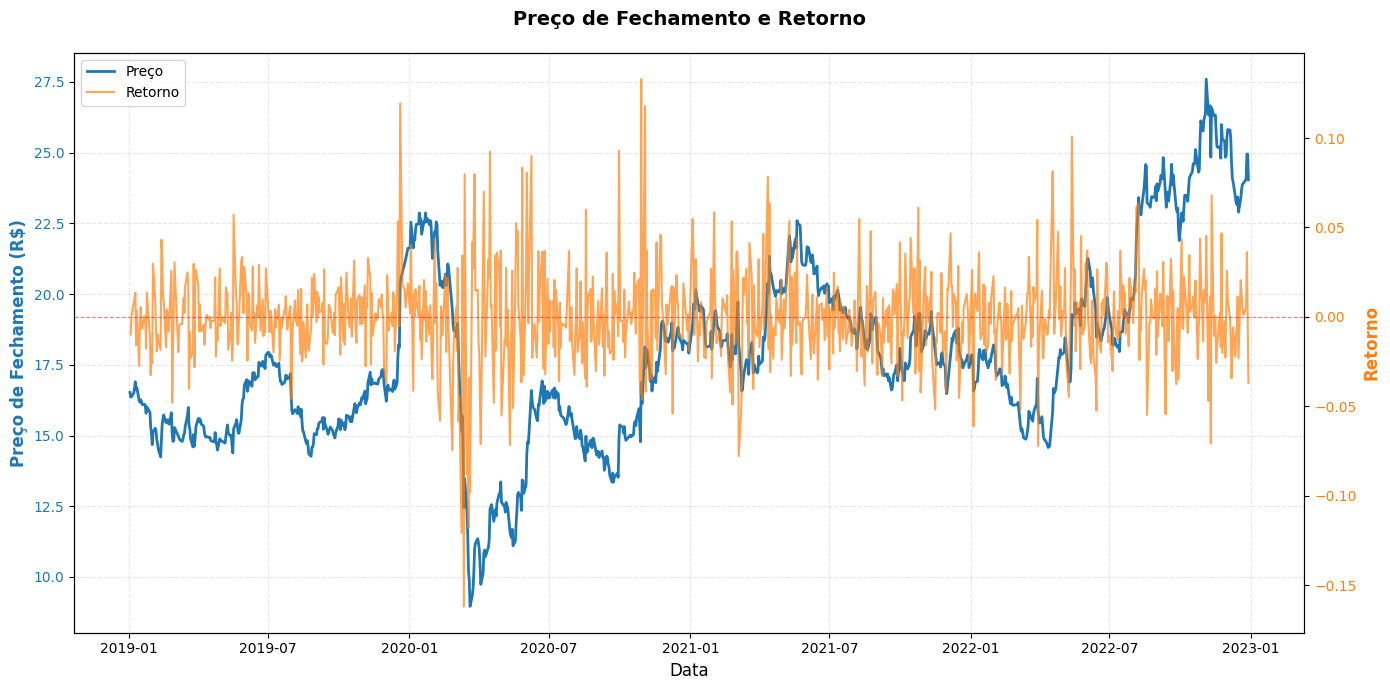

In [4]:
precos = precos[['Close']].copy()
precos['retorno'] =  np.log(precos) - np.log(precos.shift(1))

print(precos)

fig, ax1 = plt.subplots(figsize=(14, 7))

# Eixo esquerdo - Preço
color1 = '#1f77b4'
ax1.set_xlabel('Data', fontsize=12)
ax1.set_ylabel('Preço de Fechamento (R$)', color=color1, fontsize=12, fontweight='bold')
line1 = ax1.plot(precos.index, precos['Close'], color=color1, linewidth=2, label='Preço')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3, linestyle='--')

# Eixo direito - Retorno
ax2 = ax1.twinx()
color2 = '#ff7f0e'
ax2.set_ylabel('Retorno', color=color2, fontsize=12, fontweight='bold')
line2 = ax2.plot(precos.index, precos['retorno'], color=color2, linewidth=1.5, alpha=0.7, label='Retorno')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.axhline(y=0, color='red', linestyle='--', linewidth=0.8, alpha=0.5)

# Legenda combinada
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=10)

plt.title('Preço de Fechamento e Retorno', fontsize=14, fontweight='bold', pad=20)
fig.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [5]:
url = 'https://nefin.com.br/resources/risk_factors/nefin_factors.csv'
nefin = pd.read_csv(url, index_col='Date', parse_dates=True,
                    usecols=lambda x: x != 'Unnamed: 0'  # Ignora a coluna 'Unnamed: 0'
)
nefin = nefin.rename(columns={'Rm_minus_Rf': 'Market'})

nefin[converter_data(data_inicial):converter_data(data_final)]


,Market,SMB,HML,WML,IML,Risk_Free
Date,,,,,,
2019-01-02,0.035366,-0.000405,0.010850,0.004747,0.002809,0.000247
2019-01-03,0.006126,0.001102,0.004679,-0.006547,0.004548,0.000247
2019-01-04,0.002406,0.000995,0.008134,-0.000355,-0.003376,0.000247
2019-01-07,-0.002905,0.012709,0.008191,0.002229,0.008293,0.000247
2019-01-08,0.001364,-0.005847,0.003202,-0.001655,-0.002340,0.000247
...,...,...,...,...,...,...
2022-12-23,0.018342,0.015672,-0.008533,-0.005930,0.015517,0.000508
2022-12-26,-0.009463,0.007954,0.002430,-0.005992,0.007912,0.000509
2022-12-27,-0.004269,-0.021563,0.001003,0.010581,-0.021903,0.000508


In [6]:
# Calcular retorno em excesso (join automático pelos índices)
precos['retorno_excesso'] = precos['retorno'] - nefin['Risk_Free']
# Juntar os dataframes pelo índice (Date)
dados = precos.join(nefin, how='inner')

# Remover linhas com NaN
dados = dados.dropna()
dados

,Close,retorno,retorno_excesso,Market,SMB,HML,WML,IML,Risk_Free
2019-01-03,16.360659,-0.009800,-0.010046,0.006126,0.001102,0.004679,-0.006547,0.004548,0.000247
2019-01-04,16.368717,0.000492,0.000246,0.002406,0.000995,0.008134,-0.000355,-0.003376,0.000247
2019-01-07,16.505661,0.008331,0.008085,-0.002905,0.012709,0.008191,0.002229,0.008293,0.000247
2019-01-08,16.674824,0.010197,0.009950,0.001364,-0.005847,0.003202,-0.001655,-0.002340,0.000247
2019-01-09,16.900381,0.013436,0.013190,0.015597,-0.015961,-0.009897,-0.006752,-0.012168,0.000247
...,...,...,...,...,...,...,...,...,...
2022-12-23,23.933485,0.001102,0.000594,0.018342,0.015672,-0.008533,-0.005930,0.015517,0.000508
2022-12-26,24.065323,0.005493,0.004985,-0.009463,0.007954,0.002430,-0.005992,0.007912,0.000509
2022-12-27,24.953053,0.036224,0.035716,-0.004269,-0.021563,0.001003,0.010581,-0.021903,0.000508
2022-12-28,24.944263,-0.000352,-0.000861,0.014010,0.006470,0.004287,-0.013706,0.004011,0.000508


In [7]:
# Converter as datas
treino_inicio = converter_data(treino_data_inicial)
treino_fim = converter_data(treino_data_final)
teste_inicio = converter_data(teste_data_inicial)
teste_fim = converter_data(teste_data_final)


# Separar períodos de treino e teste
treino = dados.loc[treino_inicio:treino_fim]
teste = dados.loc[teste_inicio:teste_fim]

# Definir variáveis independentes (fatores) e dependente (retorno_excesso)
fatores = ['Market', 'SMB', 'HML', 'WML']

X_train = treino[fatores]
y_train = treino['retorno_excesso']

X_test = teste[fatores]
y_test = teste['retorno_excesso']

In [8]:
# Usar statsmodels (análise estatística completa)
resultado_sm = regressao_statsmodels(X_train, y_train, X_test, y_test)
obter_anova_manual(resultado_sm)



Intercepto (Alpha): -0.000431
  Erro Padrão: 0.000834
  P-valor: 0.605388

Coeficientes (Betas):
  Market:
    Coeficiente: 0.753970
    Erro Padrão: 0.047362
    P-valor: 0.000000
  SMB:
    Coeficiente: 0.438126
    Erro Padrão: 0.083518
    P-valor: 0.000000
  HML:
    Coeficiente: 0.343820
    Erro Padrão: 0.115590
    P-valor: 0.003037
  WML:
    Coeficiente: 0.047834
    Erro Padrão: 0.085990
    P-valor: 0.578205

--------------------------------------------------------------------------------
ESTATÍSTICAS DO MODELO
--------------------------------------------------------------------------------
R²: 0.3401
R² Ajustado: 0.3362
Estatística F: 89.2728
P-valor F: 0.000000
REGRESSÃO COM STATSMODELS --- SUMMARY
                            OLS Regression Results                            
Dep. Variable:        retorno_excesso   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   

,Fonte de Variação,GL,SQ,MQ,F,P-valor
0,Regressão,4,0.171855,0.042964,89.2728,0.000000
1,Resíduo,693,0.333516,0.000481,-,-
2,Total,697,0.505371,-,-,-


In [9]:
# Extrair betas (sem o intercepto)
betas = resultado_sm['coeficientes'][['Market', 'HML', 'WML', 'SMB']].values
intercepto = resultado_sm['coeficientes']['const']

# MATRIZ.MULT equivalente em Python
fatores_matrix = teste[['Market', 'HML', 'WML', 'SMB']].values
retorno_fatores = np.dot(fatores_matrix, betas)

# Adicionar intercepto e Risk_Free
retorno_reconstruido = intercepto + retorno_fatores + teste['Risk_Free'].values

# Criar Series com o resultado
retorno_reconstruido = pd.Series(
    retorno_reconstruido, 
    index = teste.index, 
    name  = 'retorno_reconstruido'
)


# Calcular erro
erro = retorno_reconstruido - teste['retorno_excesso'].values

print(f"Erro médio: {np.mean(erro):.6f}")
print(f"RMSE: {np.sqrt(np.mean(erro**2)):.6f}")

retorno_reconstruido

Erro médio: -0.000368
RMSE: 0.020050


2021-10-27   -0.007548
2021-10-28   -0.015230
2021-10-29   -0.021644
2021-11-01    0.023807
2021-11-03   -0.001697
                ...   
2022-12-23    0.017555
2022-12-26   -0.003024
2022-12-27   -0.011738
2022-12-28    0.014293
2022-12-29    0.004543
Name: retorno_reconstruido, Length: 294, dtype: float64

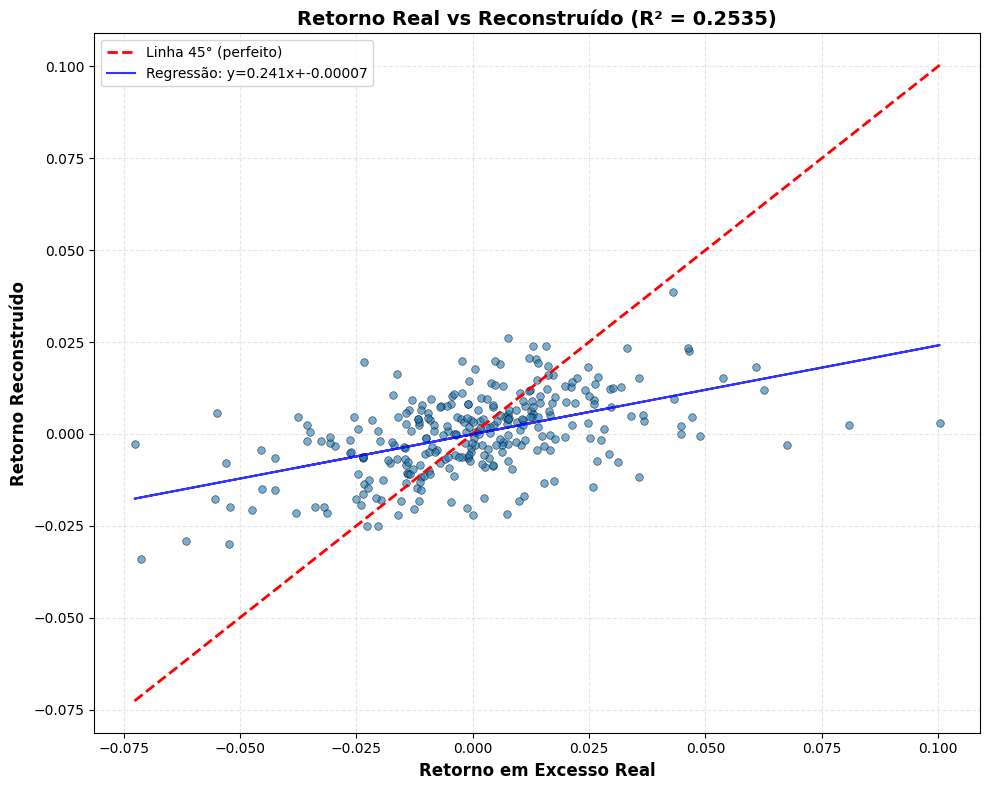

R² do ajuste: 0.2535
Correlação: 0.5044


In [10]:
# Alinhar índices
comum = teste.index.intersection(teste.index)
real = teste.loc[comum, 'retorno_excesso'].values
reconstruido = retorno_reconstruido[:len(comum)]

# Criar scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(real, reconstruido, alpha=0.6, s=30, edgecolors='black', linewidth=0.5)

# Linha de 45 graus (predição perfeita)
min_val = min(real.min(), reconstruido.min())
max_val = max(real.max(), reconstruido.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Linha 45° (perfeito)')

# Linha de regressão
z = np.polyfit(real, reconstruido, 1)
p = np.poly1d(z)
plt.plot(real, p(real), 'b-', linewidth=1.5, alpha=0.8, label=f'Regressão: y={z[0]:.3f}x+{z[1]:.5f}')

# Calcular R²
r2 = r2_score(real, reconstruido)

plt.xlabel('Retorno em Excesso Real', fontsize=12, fontweight='bold')
plt.ylabel('Retorno Reconstruído', fontsize=12, fontweight='bold')
plt.title(f'Retorno Real vs Reconstruído (R² = {r2:.4f})', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

print(f"R² do ajuste: {r2:.4f}")
print(f"Correlação: {np.corrcoef(real, reconstruido)[0,1]:.4f}")

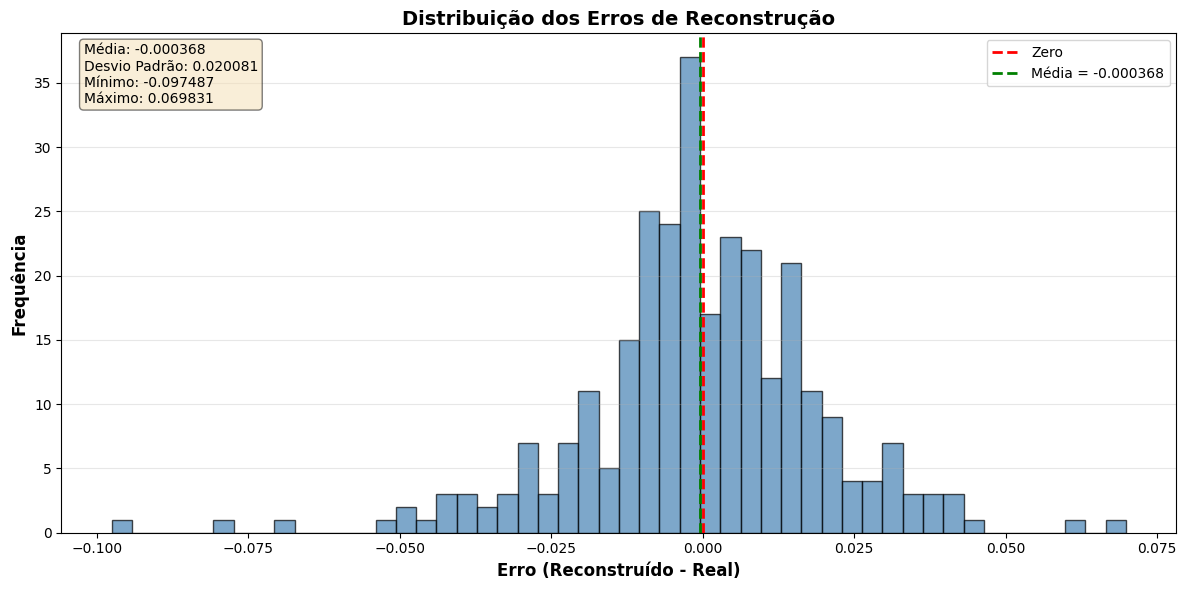

ESTATÍSTICAS DOS ERROS
Média: -0.000368
Mediana: -0.000834
Desvio Padrão: 0.020081
Mínimo: -0.097487
Máximo: 0.069831
RMSE: 0.020050


In [11]:
# Histograma dos erros
plt.figure(figsize=(12, 6))

# Histograma
plt.hist(erro, bins=50, edgecolor='black', alpha=0.7, color='steelblue')

# Linha vertical no zero
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero')

# Linha vertical na média
plt.axvline(x=erro.mean(), color='green', linestyle='--', linewidth=2, label=f'Média = {erro.mean():.6f}')

# Estatísticas
plt.xlabel('Erro (Reconstruído - Real)', fontsize=12, fontweight='bold')
plt.ylabel('Frequência', fontsize=12, fontweight='bold')
plt.title('Distribuição dos Erros de Reconstrução', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, axis='y')

# Adicionar texto com estatísticas
stats_text = f'Média: {erro.mean():.6f}\nDesvio Padrão: {erro.std():.6f}\nMínimo: {erro.min():.6f}\nMáximo: {erro.max():.6f}'
plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
         fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Imprimir estatísticas detalhadas
print("=" * 60)
print("ESTATÍSTICAS DOS ERROS")
print("=" * 60)
print(f"Média: {erro.mean():.6f}")
print(f"Mediana: {np.median(erro):.6f}")
print(f"Desvio Padrão: {erro.std():.6f}")
print(f"Mínimo: {erro.min():.6f}")
print(f"Máximo: {erro.max():.6f}")
print(f"RMSE: {np.sqrt(np.mean(erro**2)):.6f}")
print("=" * 60)